<a href="https://colab.research.google.com/github/senthilkumar-dimitra/LULC-Classification-DL/blob/expts/LULC_L8_L9_PolygonData_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install some packages
!pip install rasterio -q
!pip install earthpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.4 MB/s eta 0:00:00


In [3]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [22]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 9
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#FF8C00', '#006400']
SAMPLE_PATH = '/content/drive/MyDrive/OG_DL/Samples_LC_Jambi_2023_points.csv'
IMAGE_PATH = '/content/drive/MyDrive/OG_DL/Landsat_Jambi_2023_points.tif'

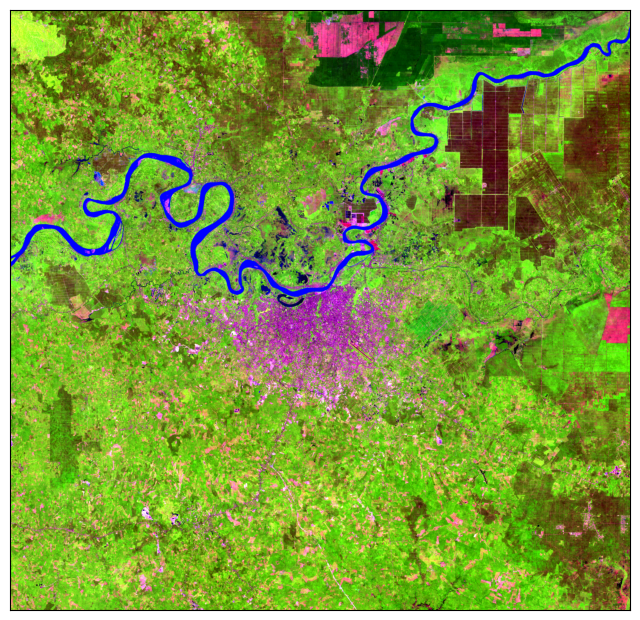

<Axes: >

In [23]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [24]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
420,0.023314,0.028456,0.056355,0.039167,0.328962,0.152055,0.061401,0.536441,0.685415,0.367778,-0.707488,-0.367778,0.424695,13,7,test
156,0.060631,0.075660,0.133121,0.170741,0.103531,0.020591,0.013771,-0.107672,0.765201,0.668211,0.125036,-0.668211,0.198472,9,2,test
158,0.053797,0.073103,0.151725,0.188547,0.143778,0.041560,0.027507,-0.064817,0.678810,0.551521,0.026895,-0.551521,0.203460,3,2,test
363,0.026572,0.032856,0.062336,0.045891,0.361041,0.185426,0.075894,0.566830,0.652609,0.321364,-0.705529,-0.321364,0.419151,9,6,test
369,0.013373,0.019257,0.035895,0.027727,0.225425,0.156702,0.067740,0.396232,0.537871,0.179842,-0.725279,-0.179842,0.396371,7,6,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.112015,0.138662,0.223720,0.282020,0.428072,0.392845,0.217560,0.175525,0.326056,0.042912,-0.313524,-0.042912,0.287162,68,1,test
258,0.031797,0.036404,0.069445,0.060191,0.360106,0.283491,0.136119,0.517728,0.451383,0.119042,-0.676663,-0.119042,0.351213,60,4,test
41,0.078410,0.108633,0.168005,0.184422,0.283807,0.337157,0.305780,0.157694,-0.037268,-0.085915,-0.256307,0.085915,0.048803,43,0,train
79,0.055805,0.064701,0.109416,0.115810,0.273069,0.245913,0.133382,0.265162,0.343673,0.052326,-0.427866,-0.052326,0.296682,16,1,train


In [25]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1, int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (381, 14, 1)
Test features: (93, 14, 1)
Train label: (381, 10)
Test label: (93, 10)


In [26]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.2
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 13, 64)            192       
                                                                 
 conv1d_9 (Conv1D)           (None, 12, 64)            8256      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 6, 64)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 5, 128)            16512     
                                                                 
 conv1d_11 (Conv1D)          (None, 4, 128)            32896     
                                                      

In [27]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 2.3113 - accuracy: 0.1102 - val_loss: 2.2395 - val_accuracy: 0.1613
Epoch 2/100
1/1 [==============================] - 0s 66ms/step - loss: 2.2823 - accuracy: 0.1050 - val_loss: 2.2340 - val_accuracy: 0.1613
Epoch 3/100
1/1 [==============================] - 0s 82ms/step - loss: 2.2542 - accuracy: 0.1365 - val_loss: 2.2236 - val_accuracy: 0.1613
Epoch 4/100
1/1 [==============================] - 0s 65ms/step - loss: 2.2340 - accuracy: 0.1260 - val_loss: 2.2103 - val_accuracy: 0.1613
Epoch 5/100
1/1 [==============================] - 0s 65ms/step - loss: 2.2515 - accuracy: 0.1024 - val_loss: 2.1982 - val_accuracy: 0.1613
Epoch 6/100
1/1 [==============================] - 0s 85ms/step - loss: 2.2182 - accuracy: 0.1129 - val_loss: 2.1858 - val_accuracy: 0.1613
Epoch 7/100
1/1 [==============================] - 0s 82ms/step - loss: 2.2170 - accuracy: 0.1312 - val_loss: 2.1743 - val_accuracy: 0.1613
Epoch 8/100
1/1 [=====

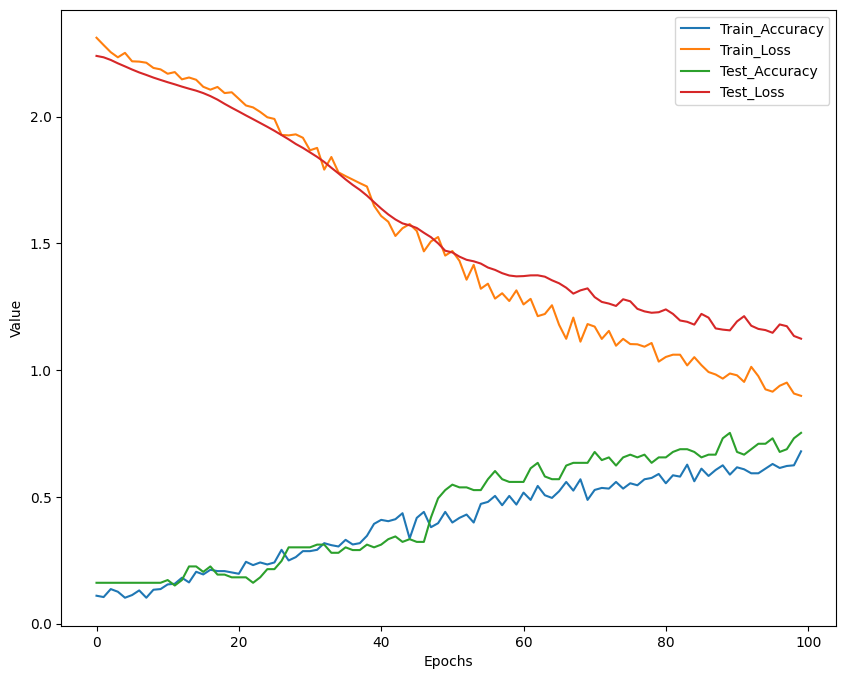

In [28]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

3/3 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        18
           1       0.60      1.00      0.75         6
           2       1.00      0.60      0.75        10
           3       0.67      0.40      0.50        10
           4       1.00      0.60      0.75        10
           5       0.75      0.50      0.60         6
           6       0.69      0.73      0.71        15
           7       0.59      1.00      0.74        10
           8       1.00      0.75      0.86         8

    accuracy                           0.75        93
   macro avg       0.79      0.73      0.73        93
weighted avg       0.79      0.75      0.74        93



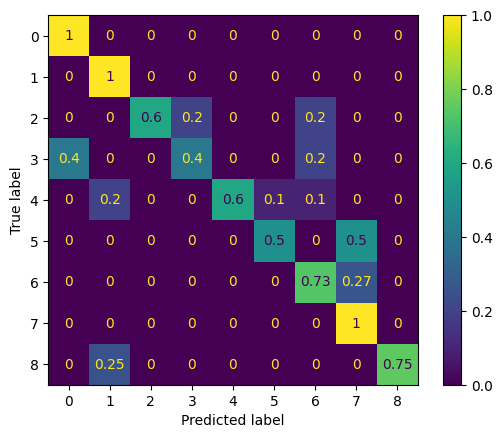

In [29]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

45/45 [==============================] - 85s 2s/step


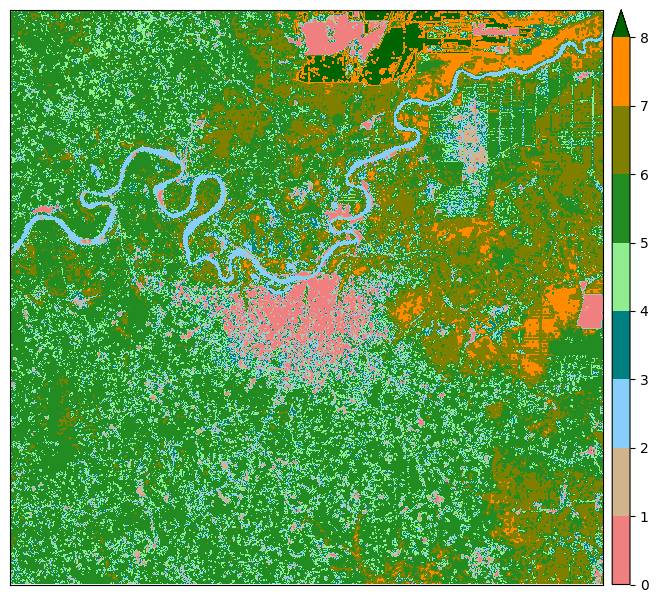

<Axes: >

In [30]:
# Predict image using the model
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

In [31]:
# Save file to drive
save_location = '/content/drive/MyDrive/OG_DL/'
name = 'LC_Jambi_2023.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()